# SSD Evaluation Tutorial

This is a brief tutorial that explains how compute the average precisions for any trained SSD model using the `Evaluator` class. The `Evaluator` computes the average precisions according to the Pascal VOC pre-2010 or post-2010 detection evaluation algorithms. You can find details about these computation methods [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#sec:ap).

As an example we'll evaluate an SSD300 on the Pascal VOC 2007 `test` dataset, but note that the `Evaluator` works for any SSD model and any dataset that is compatible with the `DataGenerator`. If you would like to run the evaluation on a different model and/or dataset, the procedure is analogous to what is shown below, you just have to build the appropriate model and load the relevant dataset.

Note: I that in case you would like to evaluate a model on MS COCO, I would recommend to follow the [MS COCO evaluation notebook](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_evaluation_COCO.ipynb) instead, because it can produce the results format required by the MS COCO evaluation server and uses the official MS COCO evaluation code, which computes the mAP slightly differently from the Pascal VOC method.

Note: In case you want to evaluate any of the provided trained models, make sure that you build the respective model with the correct set of scaling factors to reproduce the official results. The models that were trained on MS COCO and fine-tuned on Pascal VOC require the MS COCO scaling factors, not the Pascal VOC scaling factors.

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt
if('tensorflow' == K.backend()):
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
#from models.keras_ssd300 import ssd_300
from models.keras_mobilenet_v2_ssdlite import mobilenet_v2_ssd
#from keras_loss_function.keras_ssd_loss import SSDLoss
from losses.keras_ssd_loss import SSDLoss

from layers.AnchorBoxesLayer import AnchorBoxes
from layers.DecodeDetectionsLayer import DecodeDetections
from layers.DecodeDetectionsFastLayer import DecodeDetectionsFast
from layers.L2NormalizationLayer import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set a few configuration parameters.
img_height = 300
img_width = 300
n_classes = 7
model_mode = 'inference'

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # min 0.1 max 1.05 The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
#长宽比# 4 6 6 6 4 4
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters

# ??What's the meaning of the factor below??
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # 特征图cell的大小The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # 偏移值，用来确定先验框中心The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
#?? Didn't figure out the meaning of the param below
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [4]:
# 1: Build the Keras model


#Build the model
K.clear_session()

model = mobilenet_v2_ssd(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)
# train from scratch.0, 2.0, 0.5, 3.0, 1.0/3.0],h, no weights to load
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
# set_trainable(r"(ssd\_[cls|box].*)", model)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

print(model.summary())
#Total params: 3,160,240
#Trainable params: 3,108,888

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = './ssdlite-mobilenetv2-log/MobileNetv2_ssdLite_epoch-119_loss-3.0442_val_loss-2.9118.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)





This is the input shape in the model: 
3
shape of x1: (?, 300, 6)
shape of x2: (?, 300, 9)
(?, 300, 3)
shape of mask: Tensor("separate_subtraction/strided_slice_1:0", shape=(?, 300, 3), dtype=float32)






Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use `tf.cast` instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________

## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [5]:
dataset = DataGenerator()

# TODO: Set the paths to the dataset here.
Pascal_VOC_dataset_images_dir = './data_index/test/pic/'
Pascal_VOC_dataset_annotations_dir = './data_index/test/label/'
Pascal_VOC_dataset_image_set_filename = './data_index/test/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background','human','bicycle','truck','car','bus','escooter','motorbike']


dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
                  image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
                  annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'test.txt':   0%|          | 0/4445 [00:00<?, ?it/s]192.168.43.116_1596958619409
192.168.43.116_1596958681884
192.168.43.116_1596959020477
192.168.43.116_1596958663999
192.168.43.116_1596958809372
192.168.43.116_1596958679799
192.168.43.116_1596958841805
192.168.43.116_1596958809171
192.168.43.116_1596958683572
192.168.43.116_1596958842521
192.168.43.116_1596958620439
192.168.43.116_1596959033689
192.168.43.116_1596958841479
192.168.43.116_1596958920131
192.168.43.116_1596958817902
192.168.43.116_1596958684174
192.168.43.116_1596959029587
192.168.43.116_1596958696273
192.168.43.116_1596958817584
192.168.43.116_1596958991510
192.168.43.116_1596958640680
192.168.43.116_1596958724261
192.168.43.116_1596958641638
192.168.43.116_1596959034900
192.168.43.116_1596959028618
192.168.43.116_1596959034686
192.168.43.116_1596958724080
192.168.43.116_1596959022548
192.168.43.116_1596958991239
192.168.43.116_1596958842437
192.168.43.116_1596958724167
192.168.43.116_1596958807828

Processing image set 'test.txt':   8%|▊         | 369/4445 [00:00<00:03, 1213.86it/s]192.168.43.116_1596959022290
192.168.43.116_1596958695711
192.168.43.116_1596959029906
192.168.43.116_1596958667963
192.168.43.116_1596959029272
192.168.43.116_1596958645597
192.168.43.116_1596958904755
192.168.43.116_1596958991355
192.168.43.116_1596958644852
192.168.43.116_1596958678912
192.168.43.116_1596958818449
192.168.43.116_1596958684500
192.168.43.116_1596959021663
192.168.43.116_1596958678993
192.168.43.116_1596959035258
192.168.43.116_1596958921057
192.168.43.116_1596958812873
192.168.43.116_1596958813590
192.168.43.116_1596958817340
192.168.43.116_1596958903269
192.168.43.116_1596958680757
192.168.43.116_1596959035161
192.168.43.116_1596958644135
192.168.43.116_1596959029671
192.168.43.116_1596959021987
192.168.43.116_1596958817974
192.168.43.116_1596958666928
192.168.43.116_1596958812953
192.168.43.116_1596958680917
192.168.43.116_1596958723793
192.168.43.116_1596958813859
192.168.43.116_1

192.168.43.211_1596957790178
Processing image set 'test.txt':  16%|█▌        | 721/4445 [00:00<00:03, 1165.65it/s]192.168.43.211_1596958902357
192.168.43.211_1596958682185
192.168.43.211_1596958299687
192.168.43.211_1596958640831
192.168.43.211_1596958902651
192.168.43.211_1596958990719
192.168.43.211_1596959019560
192.168.43.211_1596959027890
192.168.43.211_1596958843257
192.168.43.211_1596958683160
192.168.43.211_1596958809592
192.168.43.211_1596958411594
192.168.43.211_1596958903476
192.168.43.211_1596958497849
192.168.43.211_1596958278418
192.168.43.211_1596958695006
192.168.43.211_1596958844116
192.168.43.211_1596959027959
192.168.43.211_1596958640198
192.168.43.211_1596958661813
192.168.43.211_1596958693137
192.168.43.211_1596958617802
192.168.43.211_1596958013593
192.168.43.211_1596958665077
192.168.43.211_1596958693868
192.168.43.211_1596959027260
192.168.43.211_1596957850280
192.168.43.211_1596958298240
192.168.43.211_1596958809488
192.168.43.211_1596958402041
192.168.43.211_1

192.168.43.211_1596958683792
192.168.43.211_1596958809115
192.168.43.211_1596959019431
192.168.43.211_1596958498837
192.168.43.211_1596957853258
192.168.43.211_1596958640521
192.168.43.211_1596958687562
192.168.43.211_1596958662612
192.168.43.211_1596957831826
192.168.43.211_1596957831162
192.168.43.211_1596958921548
192.168.43.211_1596958243662
Processing image set 'test.txt':  24%|██▍       | 1065/4445 [00:00<00:03, 1073.07it/s]192.168.43.211_1596958725911
192.168.43.211_1596958639422
192.168.43.211_1596958640046
192.168.43.211_1596958688122
192.168.43.211_1596959028127
192.168.43.211_1596958617491
192.168.43.211_1596957830958
192.168.43.211_1596958244781
192.168.43.211_1596957850139
192.168.43.211_1596958662280
192.168.43.211_1596958694742
192.168.43.211_1596957853172
192.168.43.211_1596958816391
192.168.43.211_1596958498733
192.168.43.211_1596958013352
192.168.43.211_1596958843721
192.168.43.211_1596958808776
192.168.43.211_1596958666199
192.168.43.211_1596958411006
192.168.43.211_

Processing image set 'test.txt':  31%|███       | 1387/4445 [00:01<00:03, 844.09it/s]192.168.43.211_1596958639651
192.168.43.211_1596958666291
192.168.43.211_1596959150402
192.168.43.211_1596958810397
192.168.43.211_1596958989583
192.168.43.211_1596958726327
192.168.43.211_1596958922427
192.168.43.211_1596958589673
192.168.43.211_1596958642283
192.168.43.211_1596958298752
192.168.43.211_1596958591511
192.168.43.211_1596958499060
192.168.43.211_1596958810953
192.168.43.211_1596958402953
192.168.43.211_1596958903123
192.168.43.211_1596958843822
192.168.43.211_1596958816635
192.168.43.211_1596957790722
192.168.43.211_1596958688370
192.168.43.211_1596958664370
192.168.43.211_1596958811115
192.168.43.211_1596958639899
192.168.43.211_1596958617750
192.168.43.211_1596958661717
192.168.43.211_1596958810068
192.168.43.211_1596958921207
192.168.43.211_1596958176296
192.168.43.211_1596958812873
192.168.43.211_1596958903306
192.168.43.211_1596958244657
192.168.43.211_1596958298413
192.168.43.211_1

192.168.43.116_1596960663186
192.168.43.116_1596960861224
192.168.43.116_1596960160739
192.168.43.116_1596960756539
192.168.43.116_1596960751922
192.168.43.116_1596960860159
192.168.43.116_1596960860755
192.168.43.116_1596960663640
192.168.43.116_1596960090431
192.168.43.116_1596960771514
192.168.43.116_1596960168821
192.168.43.116_1596960159743
192.168.43.116_1596960858659
192.168.43.116_1596960415457
192.168.43.116_1596960227587
192.168.43.116_1596960012139
192.168.43.116_1596960090903
192.168.43.116_1596960169607
192.168.43.116_1596960786789
192.168.43.116_1596960413591
192.168.43.116_1596960659798
192.168.43.116_1596960777344
192.168.43.116_1596960792693
Processing image set 'test.txt':  38%|███▊      | 1692/4445 [00:01<00:02, 937.57it/s]192.168.43.116_1596960662931
192.168.43.116_1596960159202
192.168.43.116_1596960661641
192.168.43.116_1596960159474
192.168.43.116_1596960169399
192.168.43.116_1596960390929
192.168.43.116_1596960787203
192.168.43.116_1596960758090
192.168.43.116_1

192.168.43.211_1596960857729
Processing image set 'test.txt':  45%|████▌     | 2016/4445 [00:01<00:02, 1016.86it/s]192.168.43.211_1596960093164
192.168.43.211_1596960651405
192.168.43.211_1596960021751
192.168.43.211_1596960857167
192.168.43.211_1596960394789
192.168.43.211_1596960858617
192.168.43.211_1596960092637
192.168.43.211_1596960656526
192.168.43.211_1596960654011
192.168.43.211_1596960779495
192.168.43.211_1596960653969
192.168.43.211_1596960757119
192.168.43.211_1596960223862
192.168.43.211_1596960773405
192.168.43.211_1596960652437
192.168.43.211_1596960167290
192.168.43.211_1596960656838
192.168.43.211_1596960393232
192.168.43.211_1596960224468
192.168.43.211_1596960009600
192.168.43.211_1596960790314
192.168.43.211_1596960652841
192.168.43.211_1596960416235
192.168.43.211_1596960780127
192.168.43.211_1596960653408
192.168.43.211_1596960726463
192.168.43.211_1596960416148
192.168.43.211_1596960779918
192.168.43.211_1596960166711
192.168.43.211_1596960791098
192.168.43.211_

192.168.43.211_1596960858845
192.168.43.211_1596960857646
192.168.43.211_1596960092195
192.168.43.211_1596960772709
192.168.43.211_1596960021248
192.168.43.211_1596960857229
192.168.43.211_1596960845708
192.168.43.211_1596960856848
192.168.43.211_1596960415330
192.168.43.211_1596960656450
192.168.43.211_1596960856510
192.168.43.211_1596960790467
192.168.43.211_1596960774719
192.168.43.211_1596960653886
192.168.43.211_1596960772859
192.168.43.211_1596960416384
192.168.43.211_1596960772801
192.168.43.211_1596960651892
192.168.43.211_1596960843733
192.168.43.211_1596960845813
192.168.43.211_1596960653002
192.168.43.211_1596960773190
Processing image set 'test.txt':  52%|█████▏    | 2329/4445 [00:02<00:02, 1029.57it/s]192.168.43.211_1596960655782
192.168.43.211_1596960656674
192.168.43.211_1596960091067
192.168.43.211_1596960857319
192.168.43.211_1596960974061
192.168.43.211_1596960651729
192.168.43.211_1596960780458
192.168.43.211_1596960415584
192.168.43.211_1596960774537
192.168.43.211_

192.168.43.116_1596961787395
192.168.43.116_1596961678725
192.168.43.116_1596961586951
192.168.43.116_1596961962997
192.168.43.116_1596961961499
Processing image set 'test.txt':  60%|█████▉    | 2656/4445 [00:02<00:01, 1065.48it/s]192.168.43.116_1596961675577
192.168.43.116_1596961308644
192.168.43.116_1596961349828
192.168.43.116_1596961963110
192.168.43.116_1596961977736
192.168.43.116_1596962337491
192.168.43.116_1596961787501
192.168.43.116_1596962152638
192.168.43.116_1596961982303
192.168.43.116_1596961712309
192.168.43.116_1596962369270
192.168.43.116_1596961763748
192.168.43.116_1596962289500
192.168.43.116_1596962131432
192.168.43.116_1596962328421
192.168.43.116_1596961962549
192.168.43.116_1596961587572
192.168.43.116_1596962329450
192.168.43.116_1596961608943
192.168.43.116_1596962328789
192.168.43.116_1596961882579
192.168.43.116_1596962134218
192.168.43.116_1596962028299
192.168.43.116_1596961957509
192.168.43.116_1596962152956
192.168.43.116_1596961712491
192.168.43.116_

192.168.43.116_1596962131597
192.168.43.116_1596961456585
192.168.43.116_1596961309523
192.168.43.116_1596962132707
192.168.43.116_1596961882254
192.168.43.116_1596961607306
192.168.43.116_1596961587328
192.168.43.116_1596962338398
192.168.43.116_1596962003558
192.168.43.116_1596961527580
192.168.43.116_1596961309461
192.168.43.116_1596961529115
192.168.43.116_1596961587665
192.168.43.116_1596961349366
192.168.43.116_1596962129252
192.168.43.116_1596961882411
192.168.43.116_1596961761888
192.168.43.116_1596961460517
192.168.43.116_1596961712398
192.168.43.116_1596962133676
192.168.43.116_1596962113371
192.168.43.116_1596962129208
192.168.43.116_1596961711453
192.168.43.116_1596962129908
192.168.43.116_1596962329525
192.168.43.116_1596961764299
192.168.43.116_1596961978307
192.168.43.116_1596962002521
192.168.43.116_1596961675837
192.168.43.116_1596962337039
192.168.43.116_1596961679535
192.168.43.116_1596962028999
192.168.43.116_1596961676908
192.168.43.116_1596962133418
192.168.43.116

192.168.43.211_1596962339599
192.168.43.211_1596961787739
Processing image set 'test.txt':  73%|███████▎  | 3226/4445 [00:03<00:01, 1119.39it/s]192.168.43.211_1596961870907
192.168.43.211_1596961670438
192.168.43.211_1596961976924
192.168.43.211_1596961979987
192.168.43.211_1596961609511
192.168.43.211_1596961959522
192.168.43.211_1596962127035
192.168.43.211_1596962134871
192.168.43.211_1596961787412
192.168.43.211_1596961588770
192.168.43.211_1596962154862
192.168.43.211_1596961671366
192.168.43.211_1596962112711
192.168.43.211_1596962031411
192.168.43.211_1596961348809
192.168.43.211_1596961666360
192.168.43.211_1596962221009
192.168.43.211_1596961982152
192.168.43.211_1596961670655
192.168.43.211_1596961978148
192.168.43.211_1596962113677
192.168.43.211_1596961958966
192.168.43.211_1596961759763
192.168.43.211_1596961762217
192.168.43.211_1596962136890
192.168.43.211_1596961761358
192.168.43.211_1596961789190
192.168.43.211_1596962154624
192.168.43.211_1596961670360
192.168.43.211_

192.168.43.211_1596962031322
192.168.43.211_1596961788440
192.168.43.211_1596961307647
192.168.43.211_1596961712797
192.168.43.211_1596962134633
192.168.43.211_1596961712560
192.168.43.211_1596961960148
192.168.43.211_1596961458984
192.168.43.211_1596961760577
192.168.43.211_1596962136571
192.168.43.211_1596961979753
192.168.43.211_1596961881690
192.168.43.211_1596961450772
192.168.43.211_1596961671150
192.168.43.211_1596961959028
192.168.43.211_1596961979493
192.168.43.211_1596961959201
192.168.43.211_1596961881633
192.168.43.211_1596962138469
Processing image set 'test.txt':  80%|████████  | 3561/4445 [00:03<00:00, 1066.21it/s]192.168.43.211_1596961961281
192.168.43.211_1596962113618
192.168.43.211_1596961870194
192.168.43.211_1596962126878
192.168.43.211_1596962126795
192.168.43.211_1596961981172
192.168.43.211_1596961760800
192.168.43.211_1596961713062
192.168.43.211_1596962139200
192.168.43.211_1596961451627
192.168.43.211_1596961610058
192.168.43.211_1596962137855
192.168.43.211_

192.168.43.211_1596962329686
192.168.43.211_1596961959733
192.168.43.211_1596961981821
192.168.43.211_1596961959362
192.168.43.211_1596962370774
192.168.43.211_1596961451220
192.168.43.211_1596961671228
192.168.43.211_1596961759954
192.168.43.211_1596961668438
192.168.43.211_1596961458101
192.168.43.211_1596962138155
192.168.43.211_1596962137358
192.168.43.211_1596962135836
192.168.43.211_1596961431238
192.168.43.211_1596961667948
192.168.43.211_1596962340103
192.168.43.211_1596961530149
192.168.43.211_1596961431634
192.168.43.211_1596962339285
192.168.43.211_1596961981112
192.168.43.211_1596961869947
192.168.43.211_1596961760161
192.168.43.211_1596961956964
192.168.43.211_1596961961191
192.168.43.211_1596961761601
192.168.43.211_1596961982472
192.168.43.211_1596961788390
192.168.43.211_1596961307738
192.168.43.211_1596961803437
192.168.43.211_1596962126231
192.168.43.211_1596961308579
192.168.43.211_1596961957754
192.168.43.211_1596961673404
192.168.43.211_1596962136170
192.168.43.211

Processing image set 'test.txt':  92%|█████████▏| 4106/4445 [00:03<00:00, 1039.04it/s]192.168.43.211_1596963103772
192.168.43.211_1596963055948
192.168.43.211_1596963114175
192.168.43.211_1596962851720
192.168.43.211_1596963533525
192.168.43.211_1596963100814
192.168.43.211_1596962487292
192.168.43.211_1596962591254
192.168.43.211_1596963115390
192.168.43.211_1596962518006
192.168.43.211_1596963534007
192.168.43.211_1596963482289
192.168.43.211_1596963570382
192.168.43.211_1596963054918
192.168.43.211_1596963481545
192.168.43.211_1596963055639
192.168.43.211_1596963088345
192.168.43.211_1596962851563
192.168.43.211_1596963030608
192.168.43.211_1596963568682
192.168.43.211_1596962959412
192.168.43.211_1596963568525
192.168.43.211_1596962518561
192.168.43.211_1596963027410
192.168.43.211_1596962546514
192.168.43.211_1596963056343
192.168.43.211_1596963115698
192.168.43.211_1596963102086
192.168.43.211_1596963103201
192.168.43.211_1596962486693
192.168.43.211_1596962851097
192.168.43.211_

192.168.43.211_1596963102716
192.168.43.211_1596962591736
192.168.43.211_1596962591094
192.168.43.211_1596963087842
192.168.43.211_1596962959518
192.168.43.211_1596963104418
192.168.43.211_1596962851391
192.168.43.211_1596963031970
192.168.43.211_1596962787660
192.168.43.211_1596963114809
192.168.43.211_1596962943863
192.168.43.211_1596963088749
192.168.43.211_1596962852360
192.168.43.211_1596962790219
192.168.43.211_1596963114556
192.168.43.211_1596962487189
192.168.43.211_1596962942000
192.168.43.211_1596963101698
192.168.43.211_1596962591426
192.168.43.211_1596963481725
192.168.43.211_1596962789345
192.168.43.211_1596963088642
192.168.43.211_1596963103871
192.168.43.211_1596963027989
192.168.43.211_1596963102259
192.168.43.211_1596962942804
192.168.43.211_1596963482656
192.168.43.211_1596963100900
192.168.43.211_1596963115615
192.168.43.211_1596963569738
192.168.43.211_1596962850442
192.168.43.211_1596962852181
192.168.43.211_1596963102967
192.168.43.211_1596963113135
192.168.43.211

## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

In [6]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=100,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4445

Producing predictions batch-wise:   0%|          | 0/45 [00:00<?, ?it/s]this is batch :
./data_index/test/pic/192.168.43.116_1596958619409.pgm
0
***this is batch x ***
[[199 198 195 ... 229 229 230]
 [216 201 205 ... 241 243 244]
 [243 250 250 ... 255 255 255]
 ...
 [ 24  25  24 ...  11  11  12]
 [ 23  25  24 ...  12  11  10]
 [ 25  25  24 ...  12  12  11]]
***this is batch y ***
[[  1  92  56 124 180]]
this is labels in geometric ops, is that None? 
[[  1  92  56 124 180]]
False
1
this is batch :
./data_index/test/pic/192.168.43.116_1596958681884.pgm
1
***this is batch x ***
[[200 199 196 ... 230 230 230]
 [218 204 205 ... 235 240 244]
 [243 250 250 ... 255 255 255]
 ...
 [ 24  26  27 ...  11  11  13]
 [ 27  25  27 ...  12  12  14]
 [ 28  25  25 ...  13  12  12]]
***this is batch y ***
[[  2  26  75 113 158]]
this is labels in geometric ops, is that None? 
[[  2  26  75 113 158]]
False
1
this empty batch y is :
2
./data_index/test/pic/

ValueError: not enough values to unpack (expected 3, got 2)

## 4. Visualize the results

Let's take a look:

In [7]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

human         AP    0.16
bicycle       AP    0.863
truck         AP    0.0
car           AP    0.0
bus           AP    0.0
escooter      AP    0.0
motorbike     AP    0.0

              mAP   0.146


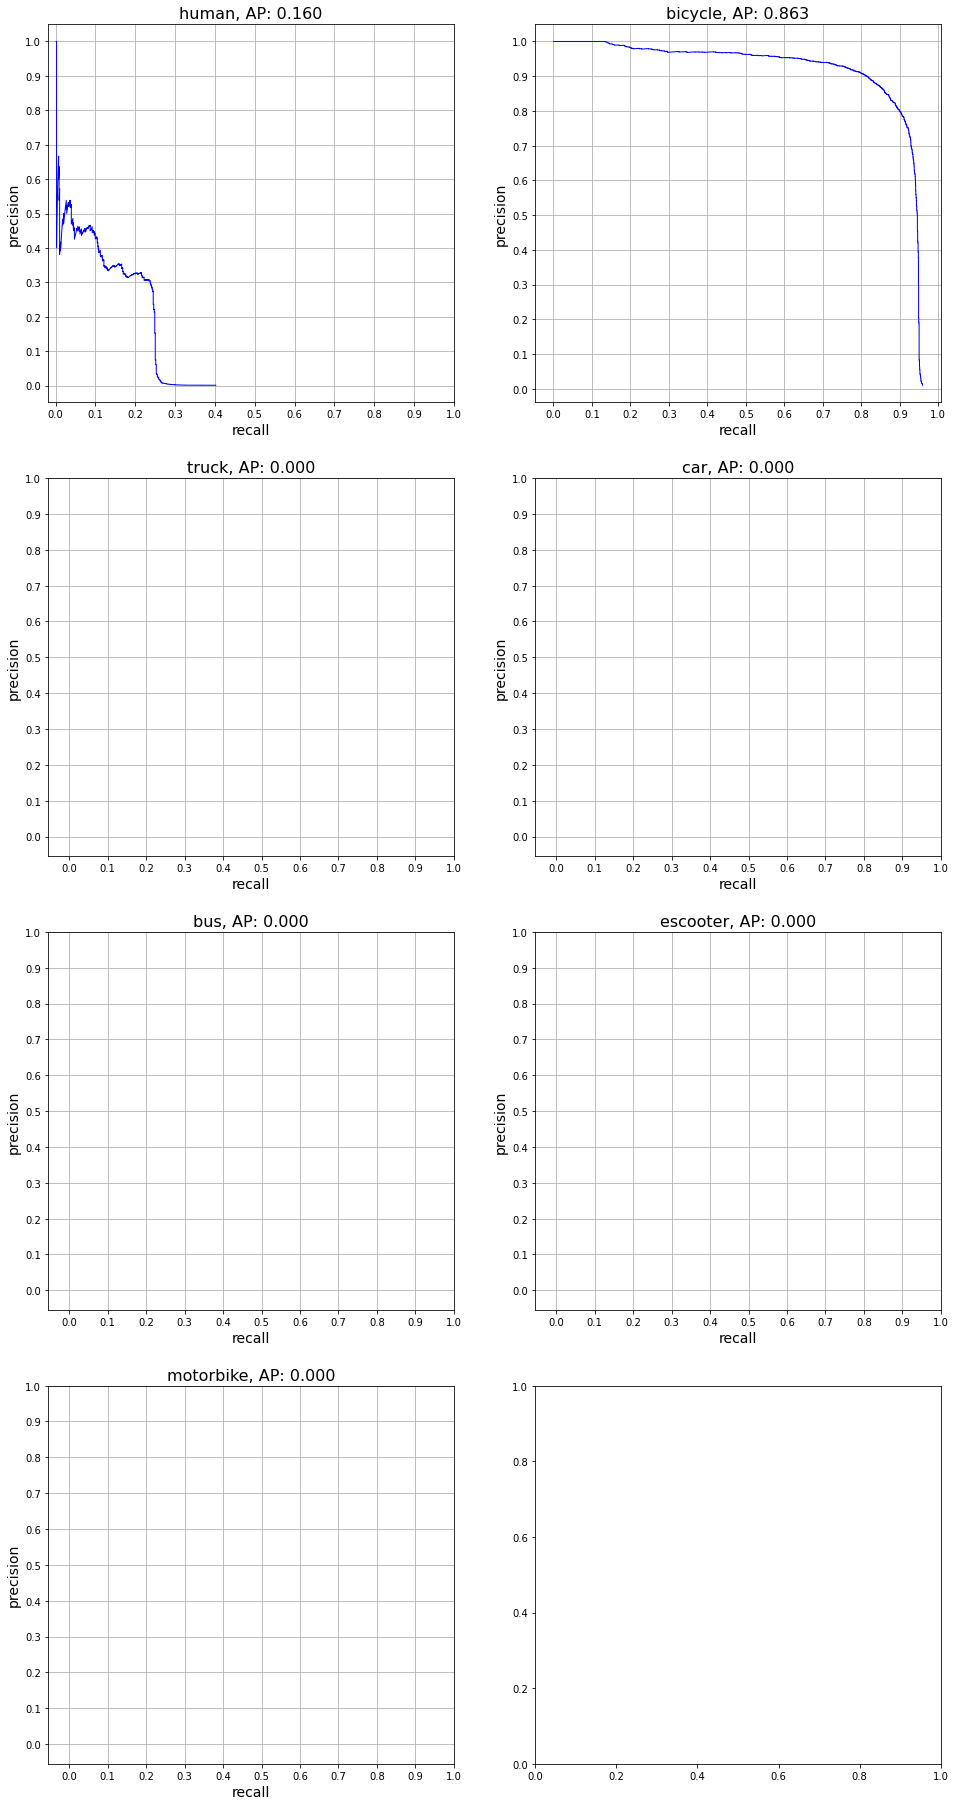

In [8]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case you want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time you make a change to a parameter. Instead, you can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. You could just call any of these other methods individually as shown below (but you have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say you wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [ ]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

In [ ]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))